--- RESULTADOS DE LA COMPARATIVA (MÉTRICA SNR) ---
FIR Hamming        | SNR: -0.84 dB
FIR Blackman       | SNR: -0.95 dB
IIR Butterworth    | SNR: -1.09 dB
IIR Chebyshev I    | SNR: -1.07 dB


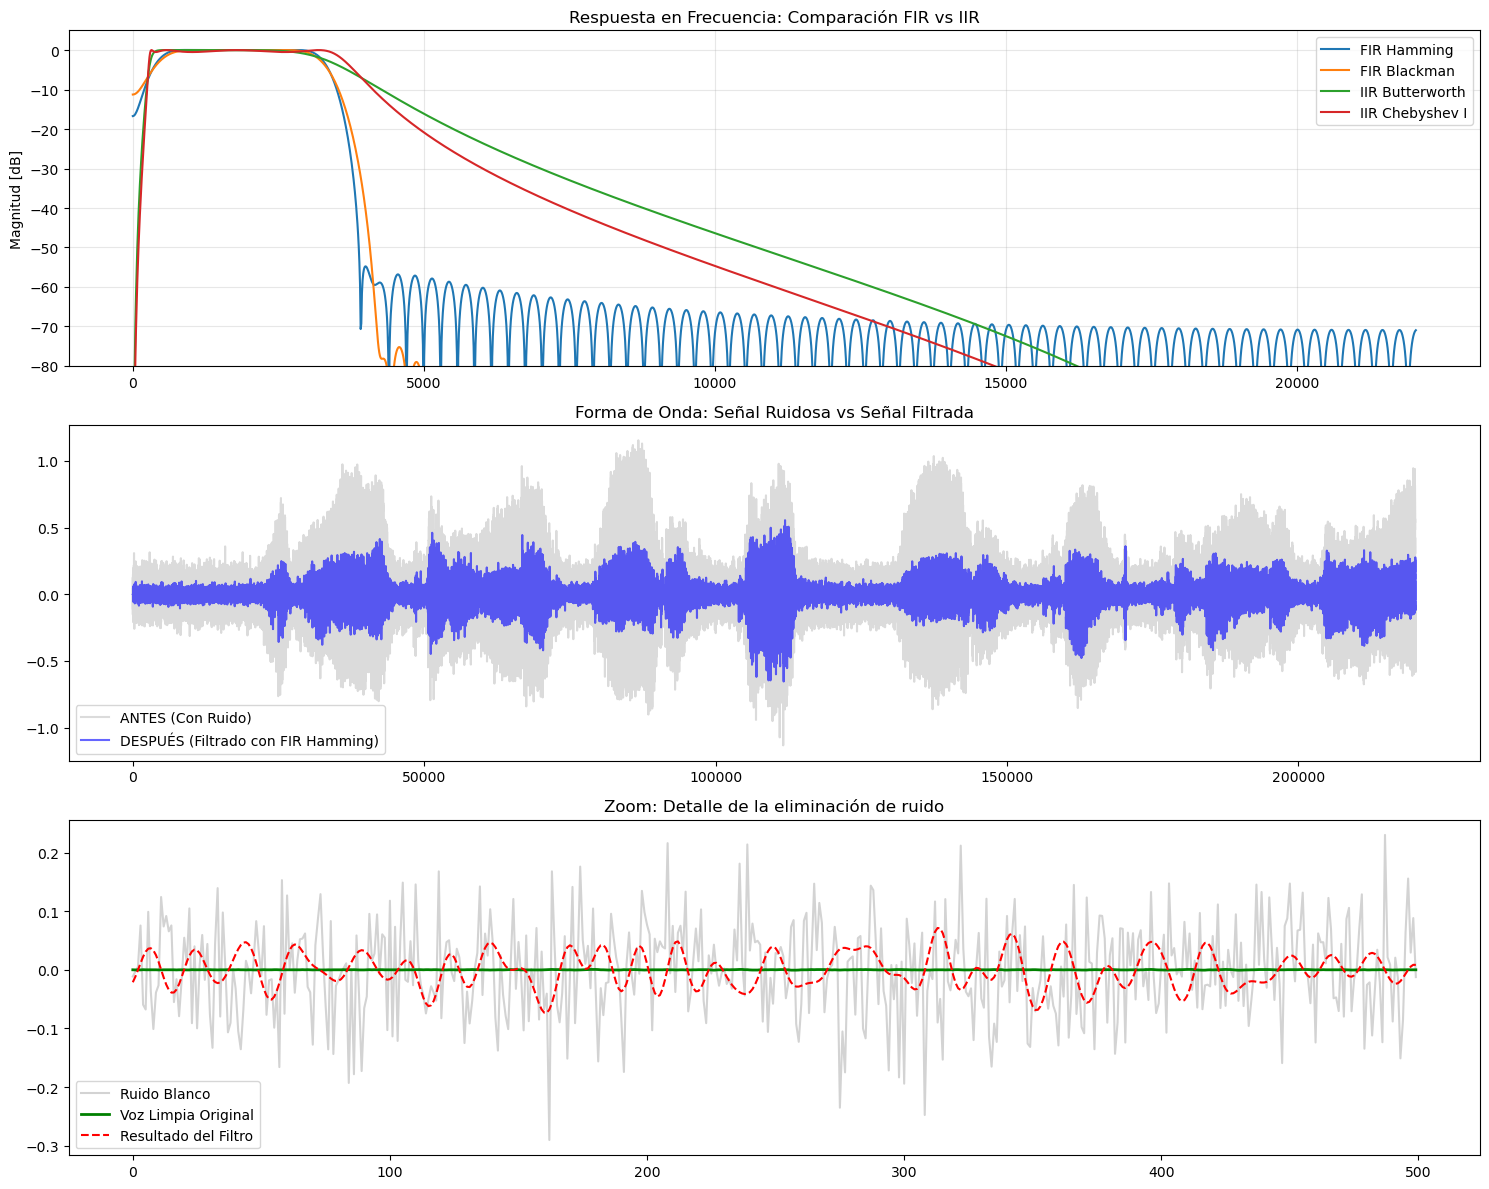


 EL FILTRO GANADOR ES: FIR Hamming
------------------------------
 ESCUCHAR ANTES (Ruido Blanco):


 ESCUCHAR DESPUÉS (Mejor Filtro: FIR Hamming):


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import firwin, lfilter, butter, cheby1, freqz
from IPython.display import Audio, display

# 1. CARGA DE AUDIO ORIGINAL
archivo = 'grabacion.wav'
Fs, data = wavfile.read(archivo)
if len(data.shape) > 1: data = data[:, 0]
data_norm = data / np.max(np.abs(data))

# 2. EL "ANTES": GENERAR RUIDO BLANCO
np.random.seed(42)
ruido_blanco = np.random.normal(0, 0.08, len(data_norm))
audio_ruidoso = data_norm + ruido_blanco

# MÉTRICA: Signal-to-Noise Ratio (SNR)
def calcular_snr(limpio, filtrado):
    potencia_señal = np.sum(limpio**2)
    potencia_ruido = np.sum((limpio - filtrado)**2)
    return 10 * np.log10(potencia_señal / potencia_ruido)

# 3. DISEÑO DE FILTROS (300Hz - 3400Hz)
nyq = 0.5 * Fs
low, high = 300/nyq, 3400/nyq

# Diccionario para almacenar resultados
resultados_audio = {}
coeficientes = {}

# --- FILTROS FIR ---
# 1. FIR Hamming
taps_ham = firwin(151, [low, high], pass_zero=False, window='hamming')
resultados_audio["FIR Hamming"] = lfilter(taps_ham, 1.0, audio_ruidoso)
coeficientes["FIR Hamming"] = (taps_ham, 1.0)

# 2. FIR Blackman
taps_blk = firwin(151, [low, high], pass_zero=False, window='blackman')
resultados_audio["FIR Blackman"] = lfilter(taps_blk, 1.0, audio_ruidoso)
coeficientes["FIR Blackman"] = (taps_blk, 1.0)

# --- FILTROS IIR ---
# 3. IIR Butterworth
b_but, a_but = butter(4, [low, high], btype='bandpass')
resultados_audio["IIR Butterworth"] = lfilter(b_but, a_but, audio_ruidoso)
coeficientes["IIR Butterworth"] = (b_but, a_but)

# 4. IIR Chebyshev I
b_che, a_che = cheby1(4, 0.5, [low, high], btype='bandpass')
resultados_audio["IIR Chebyshev I"] = lfilter(b_che, a_che, audio_ruidoso)
coeficientes["IIR Chebyshev I"] = (b_che, a_che)

# 4. EVALUACIÓN Y SELECCIÓN DEL MEJOR
print("--- RESULTADOS DE LA COMPARATIVA (MÉTRICA SNR) ---")
mejor_nombre = ""
mejor_snr = -np.inf

for nombre, audio_f in resultados_audio.items():
    snr_val = calcular_snr(data_norm, audio_f)
    print(f"{nombre:18} | SNR: {snr_val:.2f} dB")
    if snr_val > mejor_snr:
        mejor_snr = snr_val
        mejor_nombre = nombre
        mejor_audio = audio_f

# 5. VISUALIZACIÓN COMPLETA
plt.figure(figsize=(15, 12))

# Subplot A: Respuesta en Frecuencia (FIR vs IIR)
plt.subplot(3, 1, 1)
for nombre, (b, a) in coeficientes.items():
    w, h = freqz(b, a, worN=2000)
    plt.plot(0.5*Fs*w/np.pi, 20*np.log10(np.abs(h) + 1e-6), label=nombre)
plt.title("Respuesta en Frecuencia: Comparación FIR vs IIR")
plt.ylabel("Magnitud [dB]")
plt.ylim([-80, 5])
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot B: El "Antes y Después" (Señal Completa)
plt.subplot(3, 1, 2)
plt.plot(audio_ruidoso, color='lightgray', label='ANTES (Con Ruido)', alpha=0.8)
plt.plot(mejor_audio, color='blue', label=f'DESPUÉS (Filtrado con {mejor_nombre})', alpha=0.6)
plt.title("Forma de Onda: Señal Ruidosa vs Señal Filtrada")
plt.legend()

# Subplot C: Zoom a la limpieza
plt.subplot(3, 1, 3)
zoom = range(15000, 15500)
plt.plot(audio_ruidoso[zoom], color='lightgray', label='Ruido Blanco')
plt.plot(data_norm[zoom], color='green', label='Voz Limpia Original', lw=2)
plt.plot(mejor_audio[zoom], color='red', label='Resultado del Filtro', linestyle='--')
plt.title("Zoom: Detalle de la eliminación de ruido")
plt.legend()

plt.tight_layout()
plt.show()

# 6. PANEL DE AUDIOS
print(f"\n EL FILTRO GANADOR ES: {mejor_nombre}")
print("-" * 30)
print(" ESCUCHAR ANTES (Ruido Blanco):")
display(Audio(audio_ruidoso, rate=Fs))

print(f" ESCUCHAR DESPUÉS (Mejor Filtro: {mejor_nombre}):")
display(Audio(mejor_audio, rate=Fs))